# LSTM

 **일별 취급액 합계**로 LSTM 모델을 생성한다. 원래 데이터에 2020년 1월 방송 데이터가 적기 때문에, 해당 날짜의 데이터는 사용하지 않는다.

 기본 LSTM 네트워크이므로, 전체 합계를 잘 예측하는지만 확인한다. 만약 예측이 어느 정도 맞게 된다면, 하루 내에서 시간대별, 상품군 및 상품명로 매출액 구성의 가중치를 두어 예측된 매출액을 나누는 방안 등을 시도해 볼 것이다.
 
 모델 구성에서 조정한 주요 사항은 다음과 같다.

1. timestep 윈도우 사이즈

    - 윈도우 사이즈 7: 1주.
    - 윈도우 사이즈 10: 1주 + 주말 반영.
    - 윈도우 사이즈 14: 2주.

2. LSTM 단방향/양방향 여부
3. 기타 주요 파라미터: optimizer와 learning rate, 학습 epoch, (과적합이 있다면) normalization, early stopping 여부.


# 결과

 만족스러운 결과를 얻지 못했다. 오토인코더를 사용해 feature extraction한 뒤 LSTM 네트워크를 다시 구성하는 방법, 시간대별로 LSTM 네트워크를 다시 구성하는 방법을 시도해볼 예정이다.

In [1]:
# 모듈 불러오기
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pickle
import os

from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# 그래프 출력 설정
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
import matplotlib.font_manager as fm

!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()

NanumGothic Eco


In [3]:
# 경로 변경
os.chdir('/content/drive/My Drive/Big-Contest')
os.getcwd()

'/content/drive/My Drive/Big-Contest'

In [4]:
# 데이터 로드
data_raw = pd.read_excel('./data/2020 빅콘테스트 데이터분석분야-챔피언리그_2019년 실적데이터_v1_200818.xlsx', header=1)
data_raw.head(2)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0
1,2019-01-01 06:00:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0


In [5]:
# 데이터 기본 처리
data = data_raw[data_raw['상품군'] != '무형'] # 무형 상품군 제외
data['노출(분)'] = data['노출(분)'].fillna(method='ffill')
data['취급액'] = data['취급액'].fillna(0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37372 entries, 0 to 38303
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   방송일시    37372 non-null  datetime64[ns]
 1   노출(분)   37372 non-null  float64       
 2   마더코드    37372 non-null  int64         
 3   상품코드    37372 non-null  int64         
 4   상품명     37372 non-null  object        
 5   상품군     37372 non-null  object        
 6   판매단가    37372 non-null  int64         
 7   취급액     37372 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 2.6+ MB


In [6]:
# 집계 기준 컬럼 생성
data['날짜'] = data['방송일시'].dt.date
data['날짜시간'] = data['방송일시'].dt.floor('H')
data.head(10)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,날짜,날짜시간
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,2019-01-01,2019-01-01 06:00:00
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,2019-01-01,2019-01-01 06:00:00
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,2019-01-01,2019-01-01 06:00:00
3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,2019-01-01,2019-01-01 06:00:00
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,2019-01-01,2019-01-01 06:00:00
5,2019-01-01 06:40:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,9337000.0,2019-01-01,2019-01-01 06:00:00
6,2019-01-01 07:00:00,20.0,100305,200974,오모떼 레이스 파운데이션 브라,속옷,59000,6819000.0,2019-01-01,2019-01-01 07:00:00
7,2019-01-01 07:20:00,20.0,100305,200974,오모떼 레이스 파운데이션 브라,속옷,59000,15689000.0,2019-01-01,2019-01-01 07:00:00
8,2019-01-01 07:40:00,20.0,100305,200974,오모떼 레이스 파운데이션 브라,속옷,59000,25370000.0,2019-01-01,2019-01-01 07:00:00
9,2019-01-01 08:00:00,20.0,100808,202377,CERINI by PAT 남성 소프트 기모 릴렉스팬츠,의류,59900,16133000.0,2019-01-01,2019-01-01 08:00:00


# LSTM

In [7]:
def createLstmData(X_data, step, train_ratio=None):
    m = np.arange(len(X_data)-step)
    print(len(m))

    X, Y = [], []
    # 시계열 범위로 끊기
    for i in m:
        a = X_data[i:(i+step)]
        X.append(a)
        b = X_data[i+1:(i+step+1)]
        Y.append(b[-1])

    if train_ratio is not None:
        # 트레인 테스트 셋 분리
        train_num = int(len(X_data)*train_ratio)
        X_train, X_test = X[:train_num], X[train_num:]
        Y_train, Y_test = Y[:train_num], Y[train_num:]
        print("train:", len(X_train), len(Y_train))
        print("test:", len(X_test), len(Y_test))

        # 3차원 형태 변환
        X_train = np.reshape(np.array(X_train), (len(X_train), step, 1))
        Y_train = np.reshape(np.array(Y_train), (len(Y_train), 1))

        X_test = np.reshape(np.array(X_test), (len(X_test), step, 1))
        Y_test = np.reshape(np.array(Y_test), (len(Y_test), 1))

        return X_train, X_test, Y_train, Y_test
    
    else:          
        # 3차원 형태 변환
        X = np.reshape(np.array(X), (len(m), step, 1))
        Y = np.reshape(np.array(Y), (len(m), 1))

        return X, Y

In [8]:
# 일별 취급액 합계 집계
df_daily = data.groupby(by='날짜', as_index=False)['취급액'].sum()
df_daily.tail(3)

,날짜,취급액
363,2019-12-30,2.224920e+09
364,2019-12-31,2.313063e+09
365,2020-01-01,2.156940e+08


,날짜,취급액,취급액_scaled
363,2019-12-30,2.224920e+09,-0.023910
364,2019-12-31,2.313063e+09,0.231555
365,2020-01-01,2.156940e+08,-5.847262


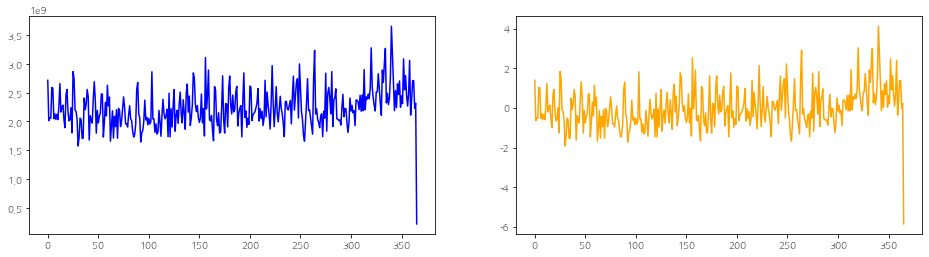

In [9]:
# 표준화 및 추이 파악
scaler = StandardScaler()
scaler.fit(df_daily[['취급액']])
df_daily['취급액_scaled'] = scaler.transform(df_daily[['취급액']])

display(df_daily.tail(3))

fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(df_daily['취급액'], color='blue')
ax2.plot(df_daily['취급액_scaled'], color='orange')
plt.show()

In [16]:
# 2020년 1월 1일 데이터 제외 후 LSTM 데이터 생성
data = df_daily['취급액_scaled'][:365].values
X_train, X_test, y_train, y_test = createLstmData(data, 14, 0.9)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

351
train: 328 328
test: 23 23
(328, 14, 1) (328, 1) (23, 14, 1) (23, 1)


In [22]:
# 모델 파라미터 설정
n_step = X_train.shape[1]
n_input = X_train.shape[2]
n_output = y_train.shape[1]
n_hidden = 512 # LSTM 히든 뉴런 수
n_batch = 64

# 모델 네트워크 구성
X_Input = Input(batch_shape=(None, n_step, n_input))
X_Lstm = Bidirectional(LSTM(n_hidden), merge_mode='concat')(X_Input)
y_output = Dense(n_output)(X_Lstm)

# 모델 컴파일
K.clear_session()
model = Model(X_Input, y_output)
model.compile(loss='mape', optimizer=optimizers.Adam(lr=0.001))
print("============ 모델 전체 구조 확인 ============")
print(model.summary())

============ 모델 전체 구조 확인 ============
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14, 1)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 1024)              2105344   
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 2,106,369
Trainable params: 2,106,369
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
# custom early stopper
# 출처: https://stackoverflow.com/questions/46287403/is-there-a-way-to-implement-early-stopping-in-keras-only-after-the-first-say-1
# restore_best_weights 추가
class CustomStopper(keras.callbacks.EarlyStopping):
    def __init__(self, patience, monitor='val_loss', min_delta=0, verbose=1, mode='auto', start_epoch=100, restore_best_weights=True): # add argument for starting epoch
        super(CustomStopper, self).__init__()
        self.start_epoch = start_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch > self.start_epoch:
            super().on_epoch_end(epoch, logs)

In [23]:
# 모델 학습
# es = CustomStopper(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
# es = EarlyStopping(monitor='val_loss', patience=50, verbose=1)
hist = model.fit(X_train, y_train,
                 validation_split=0.1,
                 epochs=300,
                 batch_size=n_batch,
                 shuffle=True)
                 # callbacks=[es])

Epoch 1/300
5/5 [==============================] - 3s 506ms/step - loss: 126.4217 - val_loss: 100.6736
Epoch 2/300
5/5 [==============================] - 2s 362ms/step - loss: 109.3752 - val_loss: 102.7329
Epoch 3/300
5/5 [==============================] - 2s 357ms/step - loss: 114.7001 - val_loss: 92.9860
Epoch 4/300
5/5 [==============================] - 2s 365ms/step - loss: 106.7068 - val_loss: 95.7584
Epoch 5/300
5/5 [==============================] - 2s 360ms/step - loss: 117.6205 - val_loss: 101.3428
Epoch 6/300
5/5 [==============================] - 2s 364ms/step - loss: 103.2995 - val_loss: 102.5856
Epoch 7/300
5/5 [==============================] - 2s 360ms/step - loss: 104.6738 - val_loss: 100.9547
Epoch 8/300
5/5 [==============================] - 2s 358ms/step - loss: 103.0375 - val_loss: 99.2740
Epoch 9/300
5/5 [==============================] - 2s 359ms/step - loss: 100.1223 - val_loss: 97.7420
Epoch 10/300
5/5 [==============================] - 2s 366ms/step - loss: 100

In [24]:
# 예측
n_future = X_test.shape[0]
estimate = [y_train[-1][0]] # 예측값 저장할 배열
for i in range(n_future):
    x = X_test[i].reshape(1, n_step, 1)
    y_hat = model.predict(x)[0][0]
    estimate.append(y_hat)

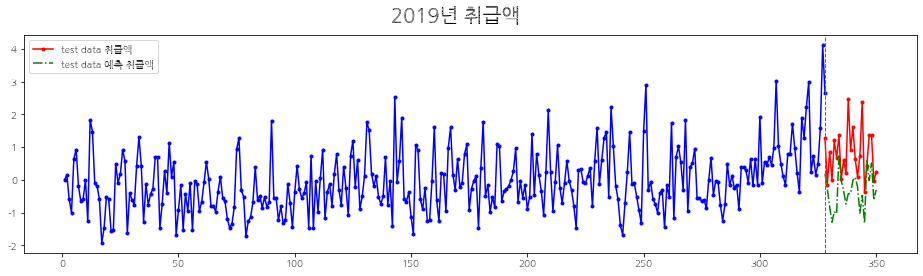

In [25]:
# 예측 결과 그래프
ax1 = np.arange(1, len(y_train)+1)
ax2 = np.arange(len(y_train), len(y_train)+len(y_test))

plt.figure(figsize=(16, 4))
plt.plot(ax1, y_train.flatten(), 'b-o', color='blue', markersize=3)
plt.plot(ax2, y_test.flatten(), 'b-o', color='red', markersize=3, label='test data 취급액')
plt.plot(ax2,  estimate[1:], linestyle='dashdot', color='green', label='test data 예측 취급액')
plt.axvline(x=ax1[-1], linestyle='dashed', linewidth=1)
plt.suptitle('2019년 취급액', size=20)
plt.legend()
plt.show()